<a href="https://colab.research.google.com/github/ale-camer/Data-Science/blob/Finance/covidCases_%2B_googleTrends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install pytrends --quiet

In [4]:
# packages

import pandas as pd
import numpy as np
from pytrends.request import TrendReq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from math import sqrt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [8]:
# COVID data
data = pd.read_excel("https://covid.ourworldindata.org/data/owid-covid-data.xlsx")
usData = data[data["location"] == "United States"] # subset US data
usData.date = pd.to_datetime(usData.date)

# Google Trends data
pytrends = TrendReq(hl="en-US",tz=360)
kwList = ['fever','cough','coronavirus symptoms','coronavirus test','coronavirus us'] # keywords
pytrends.build_payload(kwList,cat=0,timeframe="2020-01-01 2022-05-10",geo="US",gprop="")
googleData = pytrends.interest_over_time().drop(columns="isPartial")

# merging data
mergedData = googleData.merge(usData[['date','new_tests','new_cases']],left_index=True,right_on='date',how='right').set_index('date')
mergedData = mergedData.fillna(method='ffill').fillna(method='bfill') # NA treatment
mergedData.year, mergedData.month, mergedData.DOM, mergedData.DOW = mergedData.index.year, mergedData.index.month, mergedData.index.day, mergedData.index.dayofweek # time variables
mergedData

,fever,cough,coronavirus symptoms,coronavirus test,coronavirus us,new_tests,new_cases
date,,,,,,,
2020-01-22,12.0,9.0,16.0,0.0,6.0,348.0,0.0
2020-01-23,12.0,9.0,16.0,0.0,6.0,348.0,0.0
2020-01-24,12.0,9.0,16.0,0.0,6.0,348.0,1.0
2020-01-25,12.0,9.0,16.0,0.0,6.0,348.0,0.0
2020-01-26,12.0,9.0,16.0,0.0,6.0,348.0,3.0
...,...,...,...,...,...,...,...
2022-05-13,9.0,8.0,0.0,0.0,0.0,781791.0,81443.0
2022-05-14,9.0,8.0,0.0,0.0,0.0,781791.0,16092.0
2022-05-15,9.0,8.0,0.0,0.0,0.0,781791.0,30890.0


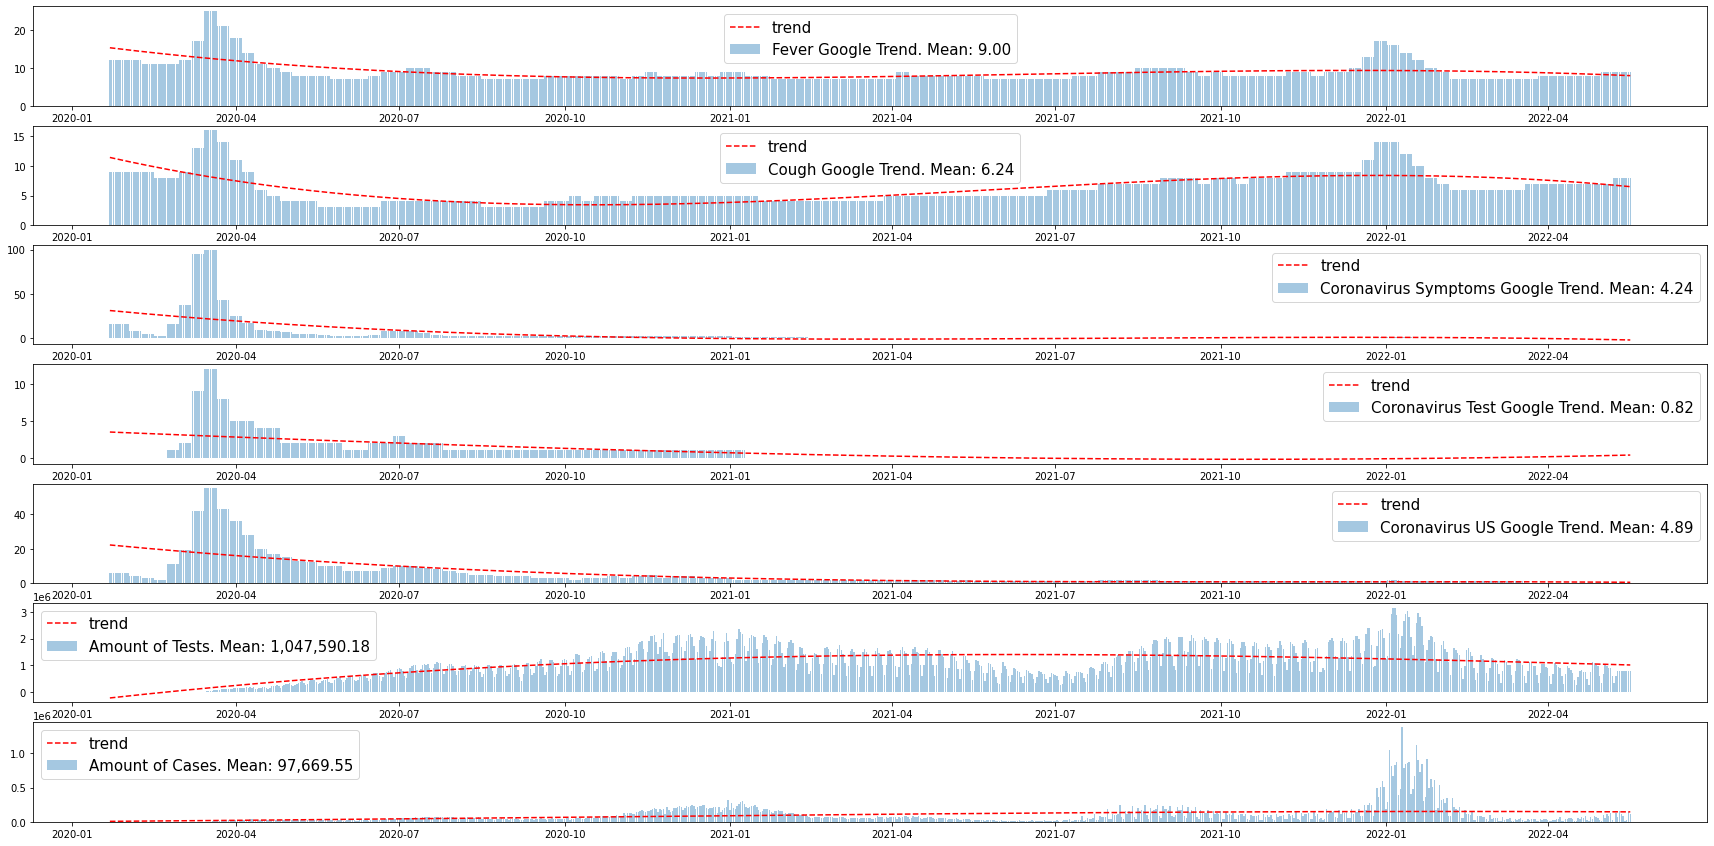

In [16]:
# time series

plt.figure(figsize=(30,15))
for name, col, num in zip(['Fever Google Trend','Cough Google Trend','Coronavirus Symptoms Google Trend','Coronavirus Test Google Trend','Coronavirus US Google Trend','Amount of Tests','Amount of Cases'], mergedData.columns, range(len(mergedData.columns))):
    plt.subplot(len(mergedData.columns),1,num+1)
    plt.bar(mergedData.index,mergedData[col],label=f'{name}. Mean: {round(mergedData[col].mean(),2):,.2f}', alpha=0.4, linewidth=2)
    z = np.polyfit(dates.date2num(mergedData.index),mergedData[col],3)
    p = np.poly1d(z)
    plt.plot(mergedData.index,p(dates.date2num(mergedData.index)),"r--", color = 'red', linewidth=1.5, label='trend')
    plt.legend(fontsize=15)
plt.show()

In [52]:
# spliting data

mergedData = mergedData[mergedData.index < '2022-05-11']
train, test = mergedData[mergedData.index < '2022-04-01'], mergedData[mergedData.index >= '2022-04-01']
xTrain, xTest, yTrain, yTest = train.drop('new_cases',axis=1), test.drop('new_cases',axis=1), train['new_cases'], test['new_cases']
xScaler, yScaler = MinMaxScaler(), MinMaxScaler()
xTrain, xTest, yTrain = xScaler.fit_transform(xTrain), xScaler.fit_transform(xTest), yScaler.fit_transform(np.array(yTrain).reshape((-1,1)))
xTrain.shape, xTest.shape, yTrain.shape, yTest.shape

((800, 6), (40, 6), (800, 1), (40,))

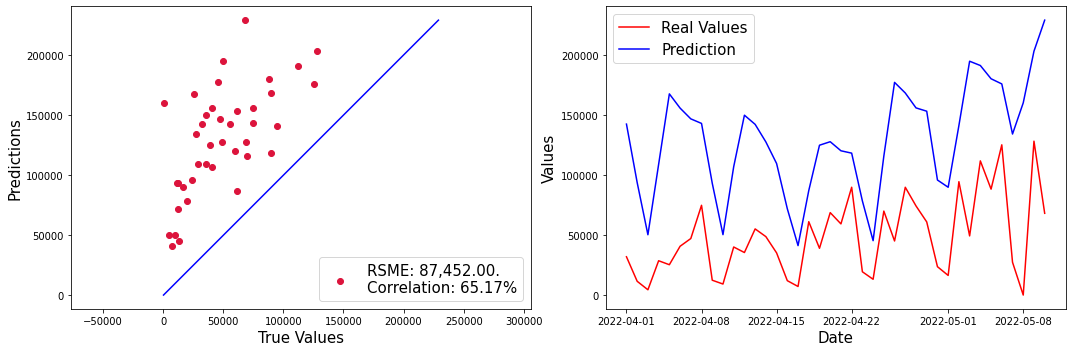

In [55]:
# prediction

model = SGDRegressor()
preds = model.fit(xTrain, yTrain).predict(xTest)
preds = pd.Series(yScaler.inverse_transform(np.array(preds).reshape((-1,1))).reshape((1,-1))[0])
preds.index = yTest.index

# plotting

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(yTest,preds,c='crimson',label='RSME: {:,.2f}.\nCorrelation: {:,.2f}%'.format(round(sqrt(mean_squared_error(yTest,preds)),0),round(np.corrcoef(yTest,preds)[0][1]*100,2)))
p1,p2 = max(max(preds),max(yTest)), min(min(preds),min(yTest))
plt.plot([p1,p2],[p1,p2],'b-')
plt.xlabel('True Values',fontsize=15)
plt.ylabel('Predictions',fontsize=15)
plt.legend(loc=0,fontsize=15)
plt.axis('equal')

plt.subplot(1,2,2)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Values',fontsize=15)
plt.plot(yTest.sort_index(),'r-', label='Real Values')
plt.plot(preds.sort_index(), 'b-', label='Prediction')
plt.legend(loc=0,fontsize=15)

plt.tight_layout()
plt.show()